In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy
import time

from funcs.model import (full_model,
                         aflare,
                         aflare_decoupled,
                         calculate_specific_flare_flux,
                         calculate_angular_radius)
from funcs.multiperiod import remove_sinusoidal
from funcs.helper import fetch_lightcurve


CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

#-----------------------------------
import numpy as np
import pandas as pd

from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve


# Different flare/active region configurations have different numbers of parameters
log_probs = {"log_probability": 7, # one flare, one active region
             "log_probability_2flares": 11, # two flares, one active region
            }

# Create a time stamp for this run
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())


In [60]:
tstamp

'30_10_2020_14_04'

In [63]:
# Read in target parameters
# ALL TARGETS MUST BE DEFINED IN THIS TABLE AND HAVE LIGHT CURVE
# OTHERWISE NOTHING WILL WORK
lcs = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")

# Choose target from table
target_N = 1
target = lcs.iloc[target_N]

# Pick up inclination and uncertainty
i_mu, i_sigma = target.i_mu, target.i_sigma

# Pick up quiescent luminosity
qlum = target.tlum * u.erg/u.s

# Pick up stellar radius
R = target.rad * R_sun

target

ID                           237880881
QCS                                  1
typ                                slc
cadence_min                          2
mission                           tess
prefix                             TIC
origin                         generic
h_mission                         TESS
SpT                                 M5
view_start                        1331
view_stop                       1333.5
view_min                           560
view_max                           700
BJDoff                         2457000
tstart                          1331.7
ampl_min                           NaN
ampl_max                           NaN
GRP                                NaN
plxmas                             NaN
eplxmas                            NaN
RA                              19.528
Dec                           -62.9831
J                                11.53
R                                  NaN
Gaia_G                         14.9796
vsini_kms                

In [108]:

# Get the light curve of the target
# from a pre-defined path
flck = fetch_lightcurve(target)

# We are dealing with ultrafast rotators witha simple sinusoidal signal
t, sflux, model, period = remove_sinusoidal(target, plot=False, save=False)

# define flare light curve so that you can use find_iterative_median later
flcd = FlareLightCurve(time=t, 
                       detrended_flux=sflux, 
                       detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))


# Choose the light curve range to use for the model fit
choice = (t > target.view_start +.55) & (t < target.view_stop-.55) 
t = t[choice]
flux = sflux[choice]

# Define the flux error
flux_err = np.nanmean(flcd.detrended_flux_err)

# Find the median flux in the chosen light curve range
# by clipping outliers iteratively
flcd = flcd[choice]
median = np.nanmean(find_iterative_median(flcd).it_med)-7


# Convert time array to rotation phase array
# using the rotation period of the star
phi = (t - t[0]) / target.Prot_d * 2 * np.pi

10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 237880881 modulation period:  8.440140530163145 h
Relative amplitude of modulation: -1.3e-02


(550.0, 750.0)

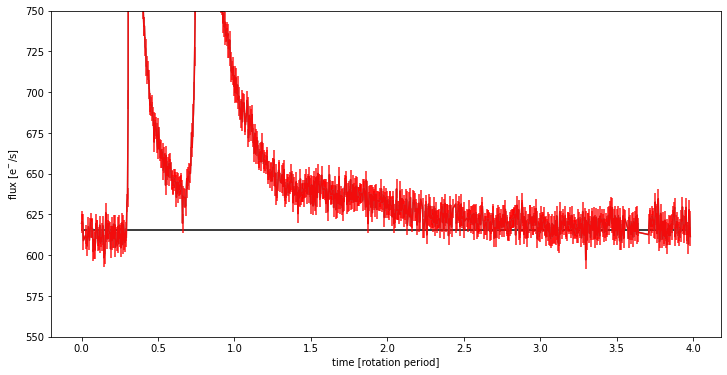

In [111]:

cf = pd.DataFrame({"phi":phi,"flux":flux, "t":t,
              "flux_err":flux_err, "median_":median})
cff = cf#f#.groupby(pd.cut(cf.phi, 900)).apply(np.mean)
# cff = cff[(cff.phi<2.43*2*np.pi) |(cff.phi>2.55*2*np.pi)]
plt.figure(figsize=(12,6))
plt.plot(cf.phi/(2*np.pi), cf.flux,color="grey")
plt.errorbar(cff.phi/(2*np.pi), cff.flux, yerr=cff.flux_err, color="r", alpha=.9)
plt.plot(cf.phi/(2*np.pi), [median]*len(cf.phi),color="k", zorder=1)

plt.xlabel("time [rotation period]")
plt.ylabel(r"flux [e$^{-}$/s]");
plt.ylim(550, 750)

In [112]:
#cff = cff[(cff.phi<18.7) |(cff.phi>19.6)]
cff

,phi,flux,t,flux_err,median_
0,0.000000,619.675801,1331.551068,5.800927,615.294854
1,0.024845,621.076333,1331.552457,5.800927,615.294854
2,0.049690,619.339414,1331.553845,5.800927,615.294854
3,0.074535,608.982802,1331.555234,5.800927,615.294854
4,0.173915,612.524902,1331.560790,5.800927,615.294854
...,...,...,...,...,...
935,24.919587,614.657919,1332.944152,5.800927,615.294854
936,24.944432,606.842306,1332.945541,5.800927,615.294854
937,24.969277,627.903209,1332.946929,5.800927,615.294854
938,24.994122,621.402229,1332.948318,5.800927,615.294854


In [113]:
# Write out light curve to use for MCMC fit
cff = cff.dropna(how="any")
cff.to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv", index=False)

In [114]:
tstamp

'30_10_2020_14_04'

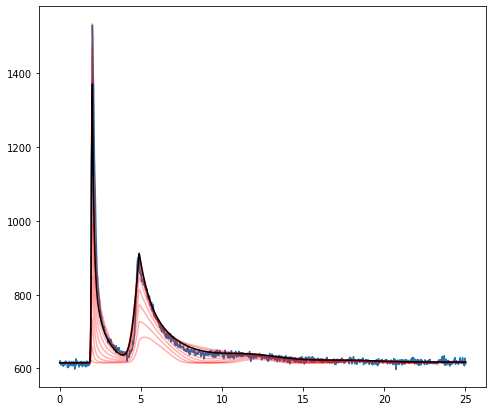

In [145]:
# Play with parameters to get a first guess for the MCMC 
# When fitting more than one flare, do one flare first, then the next etc.

# Flare peak time
phi_a =2.
# Active region latitude
theta_a = 65.2959564620278 / 180 * np.pi

# Flare amplitude
a = 1.902553675464244

# 2*FWHM of flare
fwhm1 = .15
fwhm2 = .2


phi0 =6.


Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
#---------------------------------------

# Flare peak time
phi_a2 =4.9


# Flare amplitude
a2 = .52553675464244

# 2*FWHM of flare
fwhm12 = 1.1
fwhm22 =1.4
#-----------------------------------------
#plt.plot(phi,flux)
radius = calculate_angular_radius(Fth, a, qlum, R,)
#theta_a, i_mu, phi_a, radius

plt.figure(figsize=(8,7))
plt.plot(cff.phi,cff.flux)
for i in np.linspace(0,np.pi/2,10):
    plt.plot(phi, full_model(phi_a, theta_a, a, fwhm1, fwhm2, i, phi0=phi0,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median) + full_model(phi_a2, theta_a, a2, fwhm12, fwhm22, i, phi0=phi0,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median)-median, c="r", alpha=.31,)
plt.plot(phi, full_model(phi_a, theta_a, a, fwhm1, fwhm2, i_mu, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median)+ full_model(phi_a2, theta_a, a2, fwhm12, fwhm22, i_mu, phi0=phi0,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median)-median, c="k", alpha=1,);

#plt.ylim(300,460)
#plt.yscale("log")

In [147]:
# Choose model:
log_prob = "log_probability_2flares"
nparam = log_probs[log_prob]


# Save starting points and parameters for MCMC
with open(f"{CWD}/data/summary/inits_decoupled.csv", "a") as f:
    firstout = ("date,ID,phi_a,theta_a,a,fwhm1,fwhm2,Fth,phi0,"\
                "i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,"\
                "median,log_prob,nparam\n")
    out = (f"{tstamp},{target.ID},{phi_a2},{theta_a},{a2},{fwhm12},{fwhm22},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},"\
           f"{median},{log_prob},{nparam}\n")
   # f.write(firstout)
    f.write(out)

In [58]:
10000/5./60

33.333333333333336